In [36]:
import warnings
warnings.filterwarnings('ignore')
import string
import collections
import re
from unicodedata import normalize
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.losses import sparse_categorical_crossentropy
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM, Dropout
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))


In [37]:
total_sentences = 10000
dataset = pd.read_csv("/content/Eng_-portuguese.txt", 
                      sep='\t', 
                      nrows = total_sentences, 
                      names=["EN","PT", "Attribution"], 
                      header=None)

In [38]:
english = dataset['EN']  #Separating the English and portuguese data
portuguese = dataset['PT']

In [39]:
english_words_counter = collections.Counter([word for sentence in english for word in sentence.split()])
portuguese_words_counter = collections.Counter([word for sentence in portuguese for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('20 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(20)))[0]) + '"')
print()
print('{} Portuguese words.'.format(len([word for sentence in portuguese for word in sentence.split()])))
print('{} unique French words.'.format(len(portuguese_words_counter)))
print('20 Most common words in the Portuguese dataset:')
print('"' + '" "'.join(list(zip(*portuguese_words_counter.most_common(20)))[0]) + '"')
#stats about the datasets

27930 English words.
3066 unique English words.
20 Most common words in the English dataset:
"I" "Tom" "I'm" "a" "is" "It's" "We" "was" "you" "it." "Tom." "me." "it" "They" "He" "Is" "It" "not" "you." "like"

29214 Portuguese words.
5443 unique French words.
20 Most common words in the Portuguese dataset:
"Eu" "Tom" "é" "está" "de" "o" "Não" "um" "Você" "não" "Estou" "Nós" "O" "É" "Tom." "Ele" "sou" "a" "Isso" "me"


In [40]:
test_proportion = 0.1
train_test_threshold = int( (1-test_proportion) * total_sentences)

printmd(f'## {total_sentences} "parallel sentences" will be loaded (original sentence + its translation)')
printmd(f'## {train_test_threshold} "parallel sentences" will be used to train the model')
printmd(f'## {total_sentences-train_test_threshold} "parallel sentences" will be used to test the model')

## 10000 "parallel sentences" will be loaded (original sentence + its translation)

## 9000 "parallel sentences" will be used to train the model

## 1000 "parallel sentences" will be used to test the model

In [41]:
# Shuffle the dataset
dataset = dataset.sample(frac=1, random_state=0)
dataset.iloc[1000:1010]

,EN,PT,Attribution
1554,I'm clumsy.,Sou desajeitado.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
2087,Are you new?,Vocês são novos?,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
5470,I can't do it.,Não posso fazer isso.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2363,I got dizzy.,Fiquei tonto.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
7570,Check this out.,Veja isto.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
6427,Now I'm angry.,Agora estou bravo.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1651,It's Tom's.,É do Tom.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4164,Is that mine?,Isso é meu?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1231,Birds sing.,Os pássaros cantam.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
9232,Stop grumbling.,Parem de refilar.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [42]:
def clean(string):
    # Clean the string
    string = string.replace("\u202f"," ") # Replace no-break space with space
    string = string.lower()
    
    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")
        
    string = re.sub('\s+',' ', string)
    string = string.strip()
           
    return string

dataset.drop(labels = "Attribution", axis = 1,inplace = True)

# Clean the sentences
dataset["EN"] = dataset["EN"].apply(lambda x: clean(x))
dataset["PT"] = dataset["PT"].apply(lambda x: clean(x))

# Select one part of the dataset
dataset = dataset.values
dataset = dataset[:total_sentences]

# split into train/test
train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

# Define the name of the source and of the target
# This will be used in the outputs of this notebook
source_str, target_str = "Portuguese", "English"

# The index in the numpy array of the source and of the target
idx_src, idx_tar = 1, 0

In [43]:
pd.DataFrame(dataset[1000:1050])

,0,1
0,i m clumsy,sou desajeitado
1,are you new,vocês são novos
2,i can t do it,não posso fazer isso
3,i got dizzy,fiquei tonto
4,check this out,veja isto
5,now i m angry,agora estou bravo
6,it s tom s,é do tom
7,is that mine,isso é meu
8,birds sing,os pássaros cantam
9,stop grumbling,parem de refilar


In [44]:
def create_tokenizer(lines):
    # fit a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
def max_len(lines):
    # max sentence length
    return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
    # encode and pad sequences
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X
 
def encode_output(sequences, vocab_size):
    # one hot encode target sequence
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# Prepare target tokenizer
tar_tokenizer = create_tokenizer(dataset[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(dataset[:, idx_tar])
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f'Target ({target_str}) Max Length: {tar_length}')

# Prepare source tokenizer
src_tokenizer = create_tokenizer(dataset[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(dataset[:, idx_src])
printmd(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Source ({source_str}) Max Length: {src_length}\n')
 
# Prepare training data
trainX = encode_sequences(src_tokenizer, src_length, train[:, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[:, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)

# Prepare test data
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)


Target (English) Vocabulary Size: 2055

Target (English) Max Length: 5


Source (Portuguese) Vocabulary Size: 3556

Source (Portuguese) Max Length: 8


In [48]:
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    # Create the model
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model
 
# Create model
model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

history = model.fit(trainX, 
          trainY, 
          epochs=200, 
          batch_size=64, 
          validation_split=0.1, 
          verbose=1,
          callbacks=[
                        EarlyStopping(
                        monitor='val_loss',
                        patience=2,
                        restore_best_weights=True
                    )
            ])

Epoch 1/200
127/127 [==============================] - 20s 121ms/step - loss: 4.3402 - val_loss: 3.4541
Epoch 2/200
127/127 [==============================] - 14s 112ms/step - loss: 3.2768 - val_loss: 3.2195
Epoch 3/200
127/127 [==============================] - 15s 115ms/step - loss: 3.0732 - val_loss: 3.0944
Epoch 4/200
127/127 [==============================] - 14s 110ms/step - loss: 2.9169 - val_loss: 2.9662
Epoch 5/200
127/127 [==============================] - 14s 111ms/step - loss: 2.7705 - val_loss: 2.8436
Epoch 6/200
127/127 [==============================] - 14s 110ms/step - loss: 2.5972 - val_loss: 2.6937
Epoch 7/200
127/127 [==============================] - 14s 112ms/step - loss: 2.4199 - val_loss: 2.5587
Epoch 8/200
127/127 [==============================] - 14s 112ms/step - loss: 2.2584 - val_loss: 2.4450
Epoch 9/200
127/127 [==============================] - 15s 117ms/step - loss: 2.1135 - val_loss: 2.3509
Epoch 10/200
127/127 [==============================] - 14s 110m

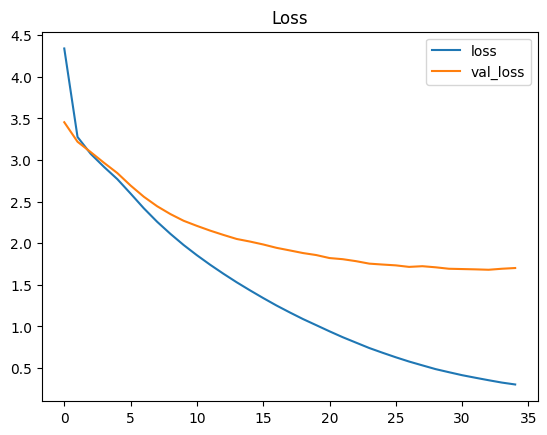

In [49]:
pd.DataFrame(history.history).plot()
plt.title("Loss")
plt.show()

In [50]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break
 
# test on some training sequences
print('### Result on the Training Set ###')
compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX, test)

### Result on the Training Set ###
PORTUGUESE (SOURCE)            ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

ambos morreram                 they both died            they both died
eu estou preso                 i m stuck                 i m stuck
eu sei disso                   i know this               i know that
eu usei uma máscara            i wore a mask             i wore a mask
me sinto perdido               i feel lost               i feel lost
eu adoro festas                i love parties            i love parties
gosto de você de verdade       i do like you             i do like you
vá devagar                     pace yourself             pace down
terminei                       i m through               i m done
descreva o tom                 describe tom              describe tom
elas sentiram                  they fell                 they fell
concordam                      they agree                they agree
eu estou chegando              i am coming   

In [51]:
def bleu_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

# Compute the BLEU Score
bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_test = bleu_score(model, tar_tokenizer, testX, test)

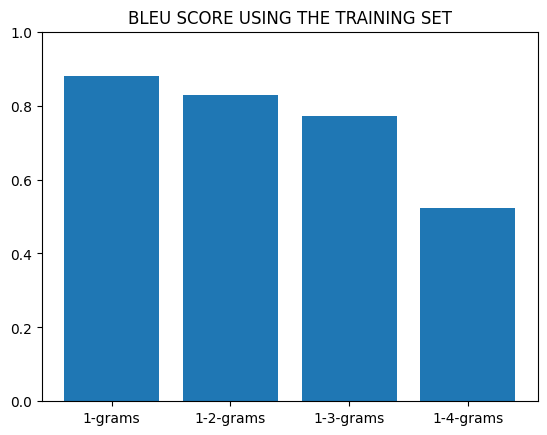

In [54]:
plt.bar(x = bleu_train.keys(), height = bleu_train.values())
plt.title("BLEU SCORE USING THE TRAINING SET")
plt.ylim((0,1))
plt.show()

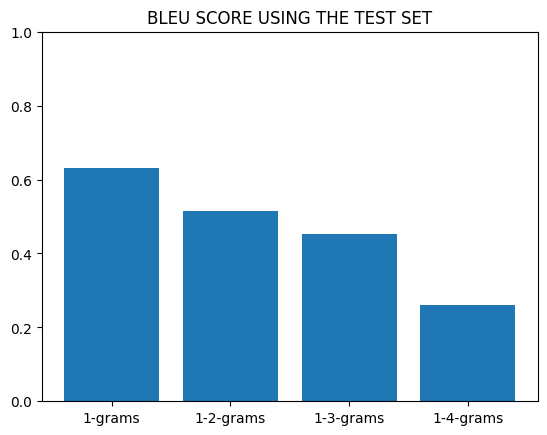

In [55]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU SCORE USING THE TEST SET")
plt.ylim((0,1))
plt.show()

In [56]:
def tokenize(x):  #breaking the raw text into small chunks
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer #These tokens help in understanding the context or developing the model for the NLP Natural Lenguage Processing

In [57]:
def pad(x, length=None): #We also have to pad each text as all the neural networks needs to have the inputs that should be in similar shape and size.
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = 55, padding = 'post')

In [58]:
def preprocess(x, y): #The preprocess function will perform both of these tokenizing and padding tasks by incorporating the 2 previously defined functions.
   
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [59]:
preproc_english_sentences, preproc_portuguese_sentences, english_tokenizer, portuguese_tokenizer = preprocess(english, portuguese)

In [60]:
def logits_to_text(logits, tokenizer): #We also need a function to convert the final prediction by our model into text form.
    
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [61]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, portuguese_vocab_size):
    
    learning_rate = 0.003
    
    # Build the layers
    model = Sequential()
    model.add(Embedding(portuguese_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(english_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=['accuracy'])
    return model

In [62]:
tmp_x = pad(preproc_portuguese_sentences, preproc_portuguese_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_portuguese_sentences.shape[-2]))

# Train 
model = bd_model(
    tmp_x.shape,
    preproc_english_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(portuguese_tokenizer.word_index)+1)

model.summary()

model.fit(tmp_x, preproc_english_sentences, batch_size=64, epochs=2, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 55, 256)           914432    
                                                                 
 bidirectional_1 (Bidirectio  (None, 55, 512)          789504    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 55, 1024)         525312    
 tributed)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 55, 1024)          0         
                                                                 
 time_distributed_7 (TimeDis  (None, 55, 2115)         2167875   
 tributed)                                                       
                                                      

In [63]:
  i=1004


  print("Prediction:")
  print(logits_to_text(model.predict(tmp_x[[i]])[0], english_tokenizer))

  print("\nCorrect Translation:")
  print(english[i])

  print("\nOriginal text:")
  print(portuguese[i])

Prediction:
1/1 [==============================] - 1s 549ms/step
it <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
Nice shot!

Original text:
Belo tiro!
